# Árboles de Decisión y Bosques

Los árboles de decisión codifican una serie de decisiones del tipo "SI" "ENTONCES", de forma similar a como las personas toman decisiones. Los árboles de decisión aprenden la pregunta a hacer y como proceder a cada posible respuesta.

Por ejemplo, si se quiere crear una guía para identificar un animal que se encuentra en la naturaleza, se podría hacer una serie de preguntas:

- ¿El animal mide más o menos de un metro?
    - más: ¿Tiene cuernos?
        - Sí: ¿Son más largos de 10cm?
        - No: ¿Tiene collar?
    - menos: ¿Tiene dos piernas o cuatro?
        - Dos: ¿Tiene alas?
        - Cuatro: ¿Tiene una cola frondosa?
        
Esta forma de hacer particiones binarias en base a preguntas es la esencia de los árboles de decisión.

Este tipo de estimadores requieren poco procesamiento de los datos. Pueden trabajar con variables de distintos tipos (continuas o discretas) y no son afectados por la escala de las variables. Otro beneficio es que son "no parámetricos", lo que quiere decir que no tienen un conjunto dijo de parámetros a aprender. en su lugar, un modelo de árbol puede ser más y más flexible, si se le proporcionan más datos. en otras palabras, el número de parámetros libres aumenta según aumentan los datos disponibles, no con valores fijos como en los modelos lineales.

## Regresión con Árboles de Decisión

Un árbol de decisión funciona de forma similar a los predictores basados en vecinos más cercanos.

In [1]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_dataset(n_samples=100):
    rnd = np.random.RandomState(42)
    x = np.linspace(-3, 3, n_samples)
    y_no_noise = np.sin(4 * x) + x
    y = y_no_noise + rnd.normal(size=len(x))
    return x, y

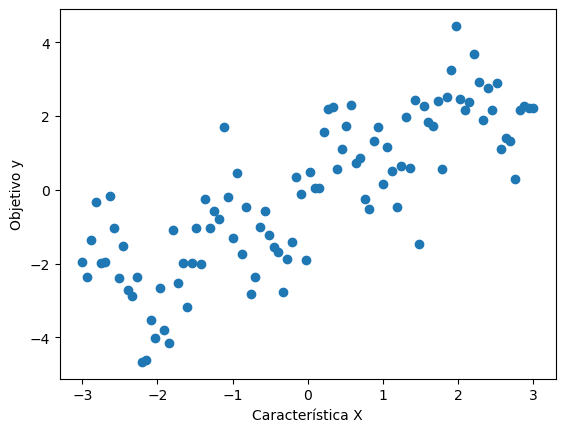

In [3]:
x, y = make_dataset()
X = x.reshape(-1, 1)

plt.figure()
plt.xlabel('Característica X')
plt.ylabel('Objetivo y')
plt.scatter(X, y);

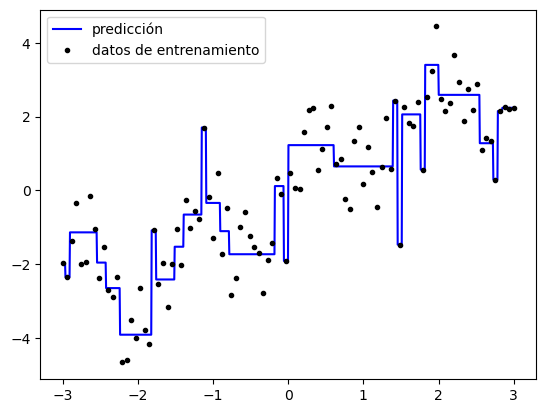

In [4]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X, y)

X_fit = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_fit_1 = reg.predict(X_fit)

plt.figure()
plt.plot(X_fit.ravel(), y_fit_1, color='blue', label="predicción")
plt.plot(X.ravel(), y, '.k', label="datos de entrenamiento")
plt.legend(loc="best");


Un único arbol de decisión permite realizar estimaciones aceptables, pero puede presentar algunos problemas. En algunas regiones, el modelo muestra un alto sesgo e infra-aprendde los datos (observe las regiones planas, donde los datos no se predicen de forma correcta), mientras que en otras el modelo muestra una varianza muy alta y sobre-aprende los datos (observe los picos pequeños que son guiados a puntos pequeños de entrenamiento - datos ruidosos). 

## Clasificación con Árboles de Decisión

Los árboles de decisión actuan de forma similar en la clasificación, asignando todos los ejemplos de una hoja a la etiqueta mayoritatia en esa hoja.

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None):
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, colors=['blue', 'red'])
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train);

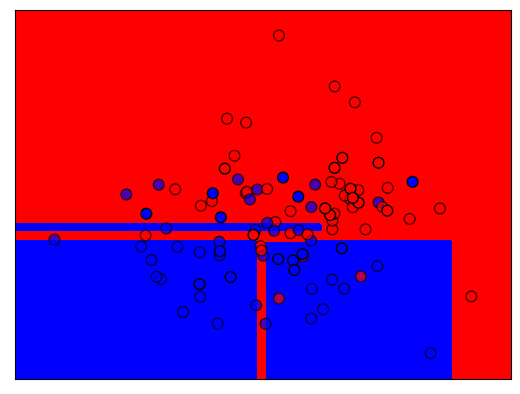

In [7]:
plt.figure()
plot_2d_separator(clf, X, fill=True)
plt.scatter(X_train[:, 0], X_train[:, 1], c=np.array(['b', 'r'])[y_train], s=60, alpha=.7, edgecolor='k')
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.array(['b', 'r'])[y_test], s=60, edgecolor='k');

Existen varios hiperparámetros que controlan la complejidad del árbol pero uno que es bastante fácil de entender es la mmáxima profundidad. Esto limita hasta que nivel se puede afinar particionando el espacio, o, lo que es lo mismo, cuantas reglas del tipo "Si-Entonces" se pueden preguntar antes de decidir la clase de un patrón.

Es importante ajustar este parámetro lo mejor posible en modelos que usen árboles de decisión. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier

from scipy import ndimage

from sklearn.tree import plot_tree as plot_tree_mpl

X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)


def plot_tree(max_depth=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if max_depth != 0:
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
        tree.fit(X, y)
        Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        faces = tree.tree_.apply(
            np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
        faces = faces.reshape(xx.shape)
        border = ndimage.laplace(faces) != 0
        ax[0].contourf(xx, yy, Z, alpha=.4, cmap='RdBu_r')
        ax[0].scatter(xx[border], yy[border], marker='.', s=1)
        ax[0].set_title("max_depth = %d" % max_depth)
        plot_tree_mpl(tree, ax=ax[1], impurity=False, filled=True)
        # ax[1].axis("off")
    else:
        ax[0].set_title("data set")
        ax[1].set_visible(False)
    ax[0].scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    ax[0].set_xticks(())
    ax[0].set_yticks(())


def plot_tree_interactive():
    from ipywidgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_tree, max_depth=slider)

In [9]:
plot_tree_interactive()

interactive(children=(IntSlider(value=0, description='max_depth', max=8), Output()), _dom_classes=('widget-int…

El gráfico interactivo muestra como se produce un infra-ajuste y sobre-ajuste para este modelo. Tener un **max_depth=1** es claramente un caso de infra-ajuste, mientras que para profundidas de 7 u 8, se observa un sobre-ajuste. La máxima profundidad para un árbol en este dataset es 8, debido a que a partir de ahí toddas las ramas tienen ejemplos de una única clase. En otras, palabras las ramas son puras.

Los árboles de decisión son rápidos de entrenar, fáciles de entender y suele llevar a modelos interpretables. Sin embargo, un solo árbol de decisión a veces tiene al sobre-ajuste. Por lo tanto, en la práctica, es más común combinar varios árboles para producir modelos que generalizan mejor. el método más común es el uso de bosques aleatorios y gradient boosted trees.

### Bosques Aleatorios

Son simplemente conjuntos de varios árboles que se han construido usando subcconjuntos aleatorios diferentes de los datos (muestreados con reemplazamiento) y subconjuntos aleatorios distintos de características (sin reemplazamiento). Esto hace que los árboles sean distintos entre si y que cada uno de ellos aprendan aspectos distintos de los datos. Al final, las predicciones se promedian, llegando a una predicción suavizada que tiene a sobre-entrenar menos.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier


X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)


def plot_forest(max_depth=1):
    plt.figure()
    ax = plt.gca()
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    if max_depth != 0:
        forest = RandomForestClassifier(n_estimators=20, max_depth=max_depth,
                                        random_state=1).fit(X, y)
        Z = forest.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap='RdBu_r')
        ax.set_title("max_depth = %d" % max_depth)
    else:
        ax.set_title("data set")
    ax.scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_forest_interactive():
    from ipywidgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_forest, max_depth=slider)

In [11]:
plot_forest_interactive()

interactive(children=(IntSlider(value=0, description='max_depth', max=8), Output()), _dom_classes=('widget-int…

#### Usando Validación Cruzada para Elegir el Estimador

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier(n_estimators=200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9],
                         'max_features': ['sqrt', 'log2', 10]})

In [13]:
clf_grid.score(X_train, y_train)

1.0

In [14]:
clf_grid.score(X_test, y_test)

0.9755555555555555

In [15]:
clf_grid.best_params_

{'max_depth': 9, 'max_features': 'sqrt'}

### Gradient Boosting

En este método en lugar de utilizar los 200 estimadores en paralelo como en el ejemplo anterior, se constuye uno por uno los 200 estimadores, donde cada uno refina los resultados del estimador anterior. La idea es que aplicando un conjunto de modelos muy simples, se obtiene al final un modelo final mejor que los modelos individuales.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.2)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9975520554767698
0.8596519437569557


#### Importancia de las Características

Las clases **Randonforest** y **GradientBoosting** tienen un atributo **features?importances_** una vez que se han entrenado. Este atributo es muy importante e interesante. Basicamente, cuantifica la contribución de cada característica al rendimiento del árbol.

In [26]:
from sklearn.datasets import load_digits
from sklearn.ensemble import GradientBoostingClassifier

digits = load_digits()
X_digits, y_digits = digits.data, digits.target

X, y = X_digits[y_digits < 2], y_digits[y_digits < 2]

rf = RandomForestClassifier(n_estimators=300, n_jobs=1)
rf.fit(X, y)
print(rf.feature_importances_)  # un valor por característica

[0.00000000e+00 3.65555530e-05 2.74867244e-04 5.18809505e-03
 4.15776652e-04 2.32111083e-03 2.15723563e-03 0.00000000e+00
 0.00000000e+00 1.02755350e-04 2.53370674e-02 6.75454639e-04
 1.11673170e-03 2.87633391e-03 2.39207822e-04 0.00000000e+00
 9.95892081e-05 7.30728768e-03 7.69734598e-03 1.75040940e-02
 7.67141177e-02 4.06796959e-03 8.98652550e-03 0.00000000e+00
 1.46045413e-04 5.32140119e-03 6.03530257e-04 7.54283800e-02
 1.36359984e-01 7.30909199e-03 6.48329928e-02 0.00000000e+00
 0.00000000e+00 3.77564437e-02 8.42663053e-03 2.83424139e-02
 1.54519358e-01 3.54641663e-03 8.63888996e-02 0.00000000e+00
 0.00000000e+00 2.37471264e-02 1.86886336e-02 8.30099762e-03
 7.89522881e-02 4.06033397e-03 3.69015636e-02 0.00000000e+00
 0.00000000e+00 9.95176726e-04 2.98384764e-02 6.97646719e-03
 1.48499846e-03 2.12487976e-03 5.05368565e-04 3.19551990e-04
 0.00000000e+00 0.00000000e+00 4.04814494e-03 6.30540505e-03
 4.28237559e-04 1.32918167e-03 1.32078723e-03 1.57267156e-03]


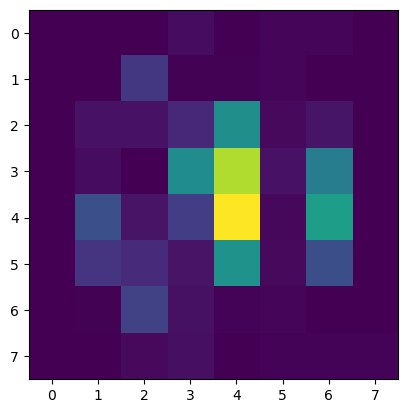

In [27]:
plt.figure()
plt.imshow(rf.feature_importances_.reshape(8, 8), cmap=plt.cm.viridis, interpolation='nearest')